In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier

import joblib

Using TensorFlow backend.


# Load Data

In [3]:
base_2018_encoded = pd.read_csv("../data/processed/base_tratada.csv")

In [9]:
print("Formato do banco de dados",base_2018_encoded.shape)
base_2018_encoded.describe()

Formato do banco de dados (9929, 449)


,ano_ingresso,frequentou_cursinho,escolaridade_pai,escolaridade_mae,forma_ingresso [Ampla concorrência],forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial],"forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]",forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)],forma_ingresso [Reserva de vagas (pessoa com deficiência)],forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)],"forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]",forma_ingresso [Transferência externa],forma_ingresso [Prefiro não responder],idade,nmr_filhos,meio_transporte [Caminhando (percurso total)],meio_transporte [Caminhando (parte do percurso)],meio_transporte [Bicicleta],meio_transporte [Carona],meio_transporte [Fretado/van],meio_transporte [Metrô],meio_transporte [Ônibus da UFABC],meio_transporte [Transporte particular (carro)],meio_transporte [Transporte particular (moto)],meio_transporte [Uber/taxi],meio_transporte [Trem],meio_transporte [Trólebus/ônibus - exceto ônibus da UFABC],meio_transporte [Prefiro não responder],tempo_medio_chegada_na_ufabc,atividade_extraclasse [Não participo de atividades extraclasse relacionadas à UFABC],atividade_extraclasse [AIESEC],atividade_extraclasse [Atividades culturais],atividade_extraclasse [Atividades de extensão],atividade_extraclasse [Atividades esportivas],atividade_extraclasse [AXIS – Atlética UFABC/CAAP],atividade_extraclasse [Coletivos de cunho religioso],atividade_extraclasse [Coletivos relacionados ao ativismo político],atividade_extraclasse [Coletivos relacionados ao empreendedorismo],atividade_extraclasse [Cursos de idiomas],atividade_extraclasse [DCE/Diretório Acadêmico/Centros Acadêmicos.],atividade_extraclasse [Empresas júniores],atividade_extraclasse [ENACTUS UFABC],atividade_extraclasse [Coletivos LGBTQ+],atividade_extraclasse [Coletivos feministas],atividade_extraclasse [Coletivos étnico-raciais],atividade_extraclasse [GPDA UFABC],atividade_extraclasse [Infanteria UFABC],atividade_extraclasse [Ramo Estudantil IEEE da UFABC],"atividade_extraclasse [Representação discente (ConsUni, ConsEPE, Comissões, etc)]",atividade_extraclasse [UFABC Cheer],atividade_extraclasse [Outras atividades extraclasse (não listadas acima)],atividade_extraclasse [Prefiro não responder],nivel_conhecimento_idioma [Alemão],nivel_conhecimento_idioma [Espanhol],nivel_conhecimento_idioma [Francês],nivel_conhecimento_idioma [Inglês],nivel_conhecimento_idioma [Italiano],nivel_conhecimento_idioma [Japonês],nivel_conhecimento_idioma [Libras],dificuldades [Nenhuma],dificuldades [Acessibilidade nas dependências da UFABC],dificuldades [Assuntos familiares/pessoais],dificuldades [Déficit de formação acadêmica básica],dificuldades [Didática dos docentes],dificuldades [Discriminações e preconceitos],dificuldades [Falta de disciplina/hábito de estudo],dificuldades [Problemas de saúde/psicológicos],dificuldades [Questões financeiras],dificuldades [Questões profissionais],dificuldades [Prefiro não responder],dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder],preconceito_discriminacao [Não],"preconceito_discriminacao [Sim, pela instituição de ensino em que cursei o ensino médio]","preconceito_discriminacao [Sim, pel

# Classificador

#### Para classificar o CR iremos excluir todos que não possuem CR registrado

In [13]:
base_2018_encoded.dropna(subset=['CR'],inplace=True)

#### Separando target

In [16]:
X = base_2018_encoded.drop(['CR','CA'],axis=1)
y = base_2018_encoded['CR']

### Análise do Target

Media do CR: 2.3
Desvio padrão: 0.76


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


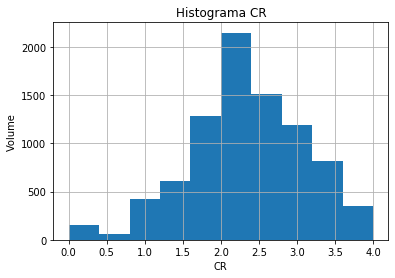

In [121]:
print('Media do CR:','{0:.2}'.format(y.mean()))
print('Desvio padrão:','{0:.2}'.format(y.std()))
fig,axs=plt.subplots(1,1)
axs.set_title('Histograma CR')
axs.set_ylabel('Volume')
axs.set_xlabel('CR')
y.hist(ax=axs)
fig.savefig('../output/figures/histograma_cr.png')
fig.show()

Distribuição do target:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


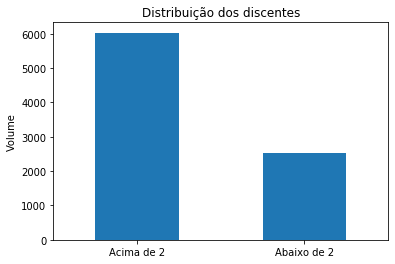

In [120]:
print('Distribuição do target:')
fig,axs=plt.subplots(1,1)
axs.set_title('Distribuição dos discentes')
axs.set_ylabel('Volume')
(y<2).map({True:'Abaixo de 2',False:'Acima de 2'}).value_counts().plot(ax=axs,kind='bar',rot=0)
fig.savefig('../output/figures/distribuicao_classes.png')
fig.show()

In [104]:
a = (y<2).value_counts()

In [91]:
a.index=['a','b']

In [109]:
axs.get_xticks()

array([0, 1])

#### Preenchendo valores nulos com a média

In [36]:
X.fillna(base_2018_encoded.mean(),inplace=True)

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [38]:
y_label = y<2

In [39]:
y_label_train = y_train<2
y_label_test = y_test<2  

In [40]:
y_label.value_counts()

False    6029
True     2540
Name: CR, dtype: int64

#### Como a base está desbalanceada, sera feito o oversample da classe alvo

In [41]:
sm = SMOTE(sampling_strategy='minority',random_state=12)

In [42]:
X_train_os, y_label_train_os = sm.fit_sample(X_train, y_label_train)

In [43]:
y_label_train_os.value_counts()

True     4536
False    4536
Name: CR, dtype: int64

In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 300, num = 10)]
# Minimum number of samples for split
min_samples_split = range(2,10)
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split':min_samples_split}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 50,
    verbose=True,
    n_jobs = 1,
    cv = 5)

In [47]:
rf_random.fit(X_train_os, y_label_train_os)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 220.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [48]:
rf_random.best_score_

0.8169467350664104

In [49]:
best_rf = rf_random.best_estimator_

In [50]:
best_rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=161, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [123]:
best_rf.fit(X_train_os,y_label_train_os)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=161, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [124]:
joblib.dump(best_rf,'../models/random_forest_classifier_cr_prediction2.pkl')

['../models/random_forest_classifier_cr_prediction2.pkl']

In [125]:
pb = best_rf.predict_proba(X_test)
probability =[]
for p in pb:
    probability.append(p[1])

In [126]:
y_score = best_rf.predict(X_test)

In [127]:
accuracy_score(y_label_test,y_score)

0.7736817545496967

## Precision vs. Recall

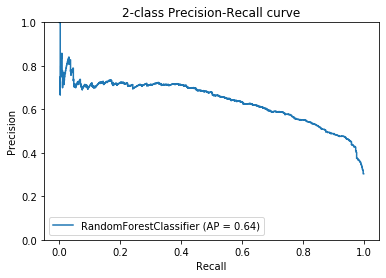

In [132]:
disp = plot_precision_recall_curve(best_rf, X_test, y_label_test)
disp.ax_.set_title('2-class Precision-Recall curve')
disp.ax_.set_ylim(0,1.0)
disp.ax_.get_figure().savefig('../output/figures/precision-recall-curve.png')

In [153]:
predict_p = [x[1] for x in best_rf.predict_proba(X_test)]
fpr,tpr, thresholds = roc_curve(y_label_test,predict_p)
aux_dict = {
    'fpr':fpr,
    'tpr':tpr,
    'thresholds': thresholds
}
df_scores = pd.DataFrame(aux_dict)

In [154]:
recalls = []
precisions = []
for i in thresholds:
    predictions_aux = predict_p>=i
    true_p = (predictions_aux==True) & (y_label_test==True)
    if(True in true_p.value_counts().index):
        tp = true_p.value_counts()[True]
    else:
        tp=0
    #print(tp)
    false_n = (predictions_aux==False) & (y_label_test==True)
    if(True in false_n.value_counts().index):
        fn = false_n.value_counts()[True]
    else:
        fn = 0
    false_p = (predictions_aux==True) & (y_label_test==False)
    if(True in false_p.value_counts().index):
        fp = false_p.value_counts()[True]
    else:
        fp = 0
    #print(fn)
    recalls.append(tp/(tp+fn))
    if((tp+fp)==0):
        precisions.append(0)
    else:
        precisions.append(tp/(tp+fp))
df_scores['recalls'] = recalls
df_scores['precisions'] = precisions

In [155]:
df_scores.loc[(df_scores['recalls']>0.75) & (df_scores['recalls']<=0.8)]

,fpr,tpr,thresholds,recalls,precisions
394,0.237776,0.750769,0.369012,0.750769,0.578885
395,0.238446,0.750769,0.368912,0.750769,0.578199
396,0.238446,0.752308,0.368369,0.752308,0.578698
397,0.241125,0.752308,0.367448,0.752308,0.575972
398,0.241125,0.755385,0.366750,0.755385,0.576968
399,0.241795,0.755385,0.366355,0.755385,0.576291
400,0.241795,0.756923,0.366327,0.756923,0.576788
401,0.243135,0.756923,0.366138,0.756923,0.575439
402,0.243135,0.758462,0.365975,0.758462,0.575935
403,0.246484,0.758462,0.363969,0.758462,0.572590


In [156]:
def predict_with_th(classificator,threshold,X):
    predictions_p = classificator.predict_proba(X)
    predictions_p_p = [x[1] for x in predictions_p]
    return [x>=threshold for x in predictions_p_p]

In [157]:
predictions_with_th = predict_with_th(best_rf,0.340457,X_test)

In [158]:
print("Acurácia do modelo implementando o Threshold para Recall 0.8 e Precision 0.55:")
print("{0:.2%}".format(accuracy_score(y_label_test,predictions_with_th)))

Acurácia do modelo implementando o Threshold para Recall 0.8 e Precision 0.55:
74.24%


In [159]:
print("ROC-Auc do modelo implementando o Threshold para Recall 0.8 e Precision 0.55:")
print("{0:.2%}".format(roc_auc_score(y_label_test,predictions_with_th)))

ROC-Auc do modelo implementando o Threshold para Recall 0.8 e Precision 0.55:
75.95%


## Roc Curve

In [150]:
def plot_roc_curve(fpr,tpr, thresholds):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.title('Roc Curve Analysis')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="center right")
    
    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])
    
    
    
    plt.savefig('../output/figures/roc_and_threshold.png')
    plt.show()
    plt.close()

In [151]:
predict_p = [x[1] for x in best_rf.predict_proba(X_test)]
fpr,tpr, thresholds = roc_curve(y_label_test,predict_p)

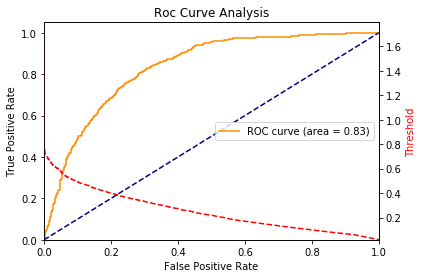

In [152]:
plot_roc_curve(fpr,tpr,thresholds)

# Compiling Results

In [67]:
results_df = pd.DataFrame(best_rf.predict_proba(X_test),columns=best_rf.classes_)
results_df['Predictions'] = best_rf.predict(X_test)
results_df['Real class'] = y_label_test.tolist()
results_df['Correct'] = results_df['Predictions']==results_df['Real class']
results_df['True Positive'] = (results_df['Predictions']==True) & (results_df['Real class']==True)
results_df['False Negative'] = (results_df['Predictions']==False) & (results_df['Real class']==True)

In [68]:
results_df 

,False,True,Predictions,Real class,Correct,True Positive,False Negative
0,0.952335,0.047665,False,False,True,False,False
1,0.269298,0.730702,True,True,True,True,False
2,0.733327,0.266673,False,False,True,False,False
3,0.653238,0.346762,False,True,False,False,True
4,0.842643,0.157357,False,False,True,False,False
...,...,...,...,...,...,...,...
2138,0.839503,0.160497,False,False,True,False,False
2139,0.417575,0.582425,True,True,True,True,False
2140,0.968581,0.031419,False,False,True,False,False
2141,0.865452,0.134548,False,False,True,False,False


# Analisando as Features

In [69]:
importances = best_rf.feature_importances_
dict_aux = {
    'name':X_train.columns.tolist(),
    'importance':importances
}
df_importancias = pd.DataFrame(dict_aux).sort_values('importance',ascending=False).reset_index().drop('index',axis=1)

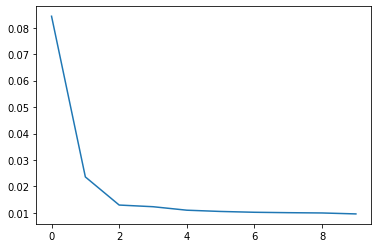

In [70]:
plt.plot(df_importancias['importance'].head(10))